In [1]:
import os
import sys

print(os.getcwd())

/Users/gorizzon/Desktop/MoGCN_TOFA


In [2]:
import numpy as np
from sklearn.metrics import accuracy_score
#import MoGCN_full

In [3]:
#print(dir(MoGCN_full))

In [4]:
import warnings

warnings.filterwarnings("ignore")

In [5]:
import pandas as pd
import numpy as np
import argparse
from tqdm import tqdm
import autoencoder_model
import torch
import torch.utils.data as Data
import snf
import seaborn as sns
import glob
import os
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import torch.nn.functional as F
from gcn_model import GCN
from utils import load_data
from utils import accuracy

def setup_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

##########################################################################################

def work(data, in_feas, lr=0.001, bs=32, epochs=100, device=torch.device('cpu'), a=0.4, b=0.3, c=0.3, mode=0, topn=100):
    
    bs = int(bs)
        
    #name of sample
    sample_name = data['Sample'].tolist()

    #change data to a Tensor
    X,Y = data.iloc[:,1:].values, np.zeros(data.shape[0])
    TX, TY = torch.tensor(X, dtype=torch.float, device=device), torch.tensor(Y, dtype=torch.float, device=device)
    #train a AE model
    if mode == 0 or mode == 1:
        Tensor_data = Data.TensorDataset(TX, TY)
        train_loader = Data.DataLoader(Tensor_data, batch_size=bs, shuffle=True)

        #initialize a model
        mmae = autoencoder_model.MMAE(in_feas, latent_dim=100, a=a, b=b, c=c)
        mmae.to(device)
        mmae.train()
        mmae.train_MMAE(train_loader, learning_rate=lr, device=device, epochs=epochs)
        mmae.eval()       #before save and test, fix the variables
        torch.save(mmae, 'model/AE/MMAE_model.pkl')

    #load saved model, used for reducing dimensions
    if mode == 0 or mode == 2:
        mmae = torch.load('model/AE/MMAE_model.pkl')
        omics_1 = TX[:, :in_feas[0]]
        omics_2 = TX[:, in_feas[0]:in_feas[0]+in_feas[1]]
        omics_3 = TX[:, in_feas[0]+in_feas[1]:in_feas[0]+in_feas[1]+in_feas[2]]
        latent_data, decoded_omics_1, decoded_omics_2, decoded_omics_3 = mmae.forward(omics_1, omics_2, omics_3)
        latent_df = pd.DataFrame(latent_data.detach().cpu().numpy())
        latent_df.insert(0, 'Sample', sample_name)
        #save the integrated data(dim=100)
        latent_df.to_csv('result/latent_data.csv', header=True, index=False)

    extract_features(data, in_feas, epochs, topn)
    return

def extract_features(data, in_feas, epochs, topn=100):
    # extract features
    #get each omics data
    data_omics_1 = data.iloc[:, 1: 1+in_feas[0]]
    data_omics_2 = data.iloc[:, 1+in_feas[0]: 1+in_feas[0]+in_feas[1]]
    data_omics_3 = data.iloc[:, 1+in_feas[0]+in_feas[1]: 1+in_feas[0]+in_feas[1]+in_feas[2]]

    #get all features of each omics data
    feas_omics_1 = data_omics_1.columns.tolist()
    feas_omics_2 = data_omics_2.columns.tolist()
    feas_omics_3 = data_omics_3.columns.tolist()

    #calculate the standard deviation of each feature
    std_omics_1 = data_omics_1.std(axis=0)
    std_omics_2 = data_omics_2.std(axis=0)
    std_omics_3 = data_omics_3.std(axis=0)

    #record top N features every 10 epochs
    topn_omics_1 = pd.DataFrame()
    topn_omics_2 = pd.DataFrame()
    topn_omics_3 = pd.DataFrame()

    #used for feature extraction, epoch_ls = [10,20,...], if epochs % 10 != 0, add the last epoch
    epoch_ls = list(range(10, epochs+10,10))
    if epochs %10 != 0:
        epoch_ls.append(epochs)
    for epoch in tqdm(epoch_ls):
        #load model
        mmae = torch.load('model/AE/model_{}.pkl'.format(epoch))
        #get model variables
        model_dict = mmae.state_dict()

        #get the absolute value of weights, the shape of matrix is (n_features, latent_layer_dim)
        weight_omics1 = np.abs(model_dict['encoder_omics_1.0.weight'].detach().cpu().numpy().T)
        weight_omics2 = np.abs(model_dict['encoder_omics_2.0.weight'].detach().cpu().numpy().T)
        weight_omics3 = np.abs(model_dict['encoder_omics_3.0.weight'].detach().cpu().numpy().T)

        weight_omics1_df = pd.DataFrame(weight_omics1, index=feas_omics_1)
        weight_omics2_df = pd.DataFrame(weight_omics2, index=feas_omics_2)
        weight_omics3_df = pd.DataFrame(weight_omics3, index=feas_omics_3)

        #calculate the weight sum of each feature --> sum of each row
        weight_omics1_df['Weight_sum'] = weight_omics1_df.apply(lambda x:x.sum(), axis=1)
        weight_omics2_df['Weight_sum'] = weight_omics2_df.apply(lambda x:x.sum(), axis=1)
        weight_omics3_df['Weight_sum'] = weight_omics3_df.apply(lambda x:x.sum(), axis=1)
        weight_omics1_df['Std'] = std_omics_1
        weight_omics2_df['Std'] = std_omics_2
        weight_omics3_df['Std'] = std_omics_3

        #importance = Weight * Std
        weight_omics1_df['Importance'] = weight_omics1_df['Weight_sum']*weight_omics1_df['Std']
        weight_omics2_df['Importance'] = weight_omics2_df['Weight_sum']*weight_omics2_df['Std']
        weight_omics3_df['Importance'] = weight_omics3_df['Weight_sum']*weight_omics3_df['Std']

        #select top N features
        fea_omics_1_top = weight_omics1_df.nlargest(topn, 'Importance').index.tolist()
        fea_omics_2_top = weight_omics2_df.nlargest(topn, 'Importance').index.tolist()
        fea_omics_3_top = weight_omics3_df.nlargest(topn, 'Importance').index.tolist()

        #save top N features in a dataframe
        col_name = 'epoch_'+str(epoch)
        topn_omics_1[col_name] = fea_omics_1_top
        topn_omics_2[col_name] = fea_omics_2_top
        topn_omics_3[col_name] = fea_omics_3_top

    #all of top N features
    #topn_omics_1.to_csv('result/topn_omics_1.csv', header=True, index=False)
    #topn_omics_2.to_csv('result/topn_omics_2.csv', header=True, index=False)
    #topn_omics_3.to_csv('result/topn_omics_3.csv', header=True, index=False)


def AE_run(path1, path2, path3, mode=0, batchsize=32, learningrate=0.001, epoch=100, latent=100, a=0.4, b=0.3, c=0.3, topn=100):
        
        #read data
    omics_data1 = pd.read_csv(path1, header=0, index_col=None)
    omics_data2 = pd.read_csv(path2, header=0, index_col=None)
    omics_data3 = pd.read_csv(path3, header=0, index_col=None)

    #Check whether GPUs are available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    #set random seed
    setup_seed(seed)

    if a + b + c != 1.0:
        print('The sum of weights must be 1.')
        exit(1)

    #dims of each omics data
    in_feas = [omics_data1.shape[1] - 1, omics_data2.shape[1] - 1, omics_data3.shape[1] - 1]
    omics_data1.rename(columns={omics_data1.columns.tolist()[0]: 'Sample'}, inplace=True)
    omics_data2.rename(columns={omics_data2.columns.tolist()[0]: 'Sample'}, inplace=True)
    omics_data3.rename(columns={omics_data3.columns.tolist()[0]: 'Sample'}, inplace=True)

    omics_data1.sort_values(by='Sample', ascending=True, inplace=True)
    omics_data2.sort_values(by='Sample', ascending=True, inplace=True)
    omics_data3.sort_values(by='Sample', ascending=True, inplace=True)

    #merge the multi-omics data, calculate on common samples
    Merge_data = pd.merge(omics_data1, omics_data2, on='Sample', how='inner')
    Merge_data = pd.merge(Merge_data, omics_data3, on='Sample', how='inner')
    Merge_data.sort_values(by='Sample', ascending=True, inplace=True)

    #train model, reduce dimensions and extract features
    
    # Suppress epoch-wise results
    sys.stdout = open(os.devnull, 'w')
    
    work(Merge_data, in_feas, lr=learningrate, bs=batchsize, epochs=epoch, device=device, a=a, b=b, c=c, mode=mode, topn=topn)
    
    # Restore stdout
    sys.stdout = sys.__stdout__


##########################################################################################

def SNF_run(path1, path2, path3, metric='cosine', K=20, mu=0.5):
    omics_data_1 = pd.read_csv(path1, header=0, index_col=None)
    omics_data_2 = pd.read_csv(path2, header=0, index_col=None)
    omics_data_3 = pd.read_csv(path3, header=0, index_col=None)

    if omics_data_1.shape[0] != omics_data_2.shape[0] or omics_data_1.shape[0] != omics_data_3.shape[0]:
        print('Input files must have same samples.')
        exit(1)

    omics_data_1.rename(columns={omics_data_1.columns.tolist()[0]: 'Sample'}, inplace=True)
    omics_data_2.rename(columns={omics_data_2.columns.tolist()[0]: 'Sample'}, inplace=True)
    omics_data_3.rename(columns={omics_data_3.columns.tolist()[0]: 'Sample'}, inplace=True)

    # align samples of different data
    omics_data_1.sort_values(by='Sample', ascending=True, inplace=True)
    omics_data_2.sort_values(by='Sample', ascending=True, inplace=True)
    omics_data_3.sort_values(by='Sample', ascending=True, inplace=True)

    affinity_nets = snf.make_affinity([omics_data_1.iloc[:, 1:].values.astype(np.float), omics_data_2.iloc[:, 1:].values.astype(np.float), omics_data_3.iloc[:, 1:].values.astype(np.float)],
                                      metric=metric, K=K, mu=mu)

    fused_net =snf.snf(affinity_nets, K=K)

    fused_df = pd.DataFrame(fused_net)
    fused_df.columns = omics_data_1['Sample'].tolist()
    fused_df.index = omics_data_1['Sample'].tolist()
    fused_df.to_csv('result/SNF_fused_matrix.csv', header=True, index=True)

    np.fill_diagonal(fused_df.values, 0)
    #fig = sns.clustermap(fused_df.iloc[:, :], cmap='vlag', figsize=(8,8),)
    #fig.savefig('result/SNF_fused_clustermap.png', dpi=300)

##########################################################################################

def train(epoch, optimizer, features, adj, labels, idx_train, device, GCN_model):
    '''
    :param epoch: training epochs
    :param optimizer: training optimizer, Adam optimizer
    :param features: the omics features
    :param adj: the laplace adjacency matrix
    :param labels: sample labels
    :param idx_train: the index of trained samples
    '''
    labels.to(device)

    GCN_model.train()
    optimizer.zero_grad()
    output = GCN_model(features, adj)
    loss_train = F.cross_entropy(output[idx_train], labels[idx_train])
    acc_train = accuracy(output[idx_train], labels[idx_train])
    loss_train.backward()
    optimizer.step()
    
    return loss_train.data.item()

def test(features, adj, labels, idx_test, GCN_model):
    '''
    :param features: the omics features
    :param adj: the laplace adjacency matrix
    :param labels: sample labels
    :param idx_test: the index of tested samples
    '''
    GCN_model.eval()
    output = GCN_model(features, adj)
    loss_test = F.cross_entropy(output[idx_test], labels[idx_test])

    #calculate the accuracy
    acc_test = accuracy(output[idx_test], labels[idx_test])

    #output is the one-hot label
    ot = output[idx_test].detach().cpu().numpy()
    #change one-hot label to digit label
    ot = np.argmax(ot, axis=1)
    #original label
    lb = labels[idx_test].detach().cpu().numpy()

    #calculate the f1 score
    f = f1_score(ot, lb, average='weighted')

    #return accuracy and f1 score
    return acc_test.item(), f


def GCN_cross_validation(featuredata, adjdata, labeldata, cv_splits, epochs=150, learningrate=0.001, weight_decay=0.01, hidden=64, dropout=0.5, nclass=4, patience=20):
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # set random seed
    setup_seed(seed)

    # load input files
    adj, data, label = load_data(adjdata, featuredata, labeldata)

    # change dataframe to Tensor
    adj = torch.tensor(adj, dtype=torch.float, device=device)
    features = torch.tensor(data.iloc[:, 1:].values, dtype=torch.float, device=device)
    #labels = torch.tensor([label.items()["Tumor"]], dtype=torch.long, device=device)
    labels = torch.tensor(label.iloc[:, 1].values, dtype=torch.long, device=device)
    
    skf = StratifiedKFold(n_splits=cv_splits, shuffle=True)
    acc_res, f1_res = [], []

    for idx_train, idx_test in skf.split(features, labels):
        GCN_model = GCN(n_in=features.shape[1], n_hid=hidden, n_out=nclass, dropout=dropout)
        GCN_model.to(device)
        optimizer = torch.optim.Adam(GCN_model.parameters(), lr=learningrate, weight_decay=weight_decay)

        idx_train, idx_test = torch.tensor(idx_train, dtype=torch.long, device=device), torch.tensor(idx_test, dtype=torch.long, device=device)

        for epoch in range(epochs):
            train(epoch, optimizer, features, adj, labels, idx_train, device, GCN_model)

        ac, f1 = test(features, adj, labels, idx_test, GCN_model)
        acc_res.append(ac)
        f1_res.append(f1)
        
    return np.mean(acc_res), np.std(acc_res), np.mean(f1_res), np.std(f1_res)



In [6]:
path1 = "data/omics1_train.csv"
path2 = "data/omics2_train.csv"
path3 = "data/omics3_train.csv"
features = "result/latent_data.csv"
adjacency = "result/SNF_fused_matrix.csv"
labels = "data/label_train.csv"

In [7]:
def run_commands(ae_params, snf_params, gcn_params, k_splits=7):
    AE_run(path1, path2, path3, mode=0, **ae_params, a=0.4, b=0.3, c=0.3, topn=100)
    # AE_run(mode=0, seed=0, path1, path2, path3, batchsize=32, learningrate=0.001, epoch=100, latent=100, a=0.4, b=0.3, c=0.3, topn=100)
    
    SNF_run(path1, path2, path3, metric='cosine', **snf_params)
    # SNF_run(path1, path2, path3, metric='sqeuclidean', K=20, mu=0.5)

    accuracy, acc_std, f1_score, f1_std = GCN_cross_validation(features, adjacency, labels, cv_splits=k_splits, **gcn_params, nclass=3, patience=50)
    # GCN_cross_validation(features, adj, labels, cv_splits, epochs=150, learningrate=0.001, weight_decay=0.01, hidden=64, dropout=0.5, nclass=4, patience=20)

    # return performance metrics
    return accuracy, acc_std, f1_score, f1_std

In [13]:
# function to perform hyperparameter search and evaluation
def hyperparameter_search(k_splits=7): 

    # Sample hyperparameters from predefined distributions
    ae_params = {
        'batchsize': np.random.choice([32, 64, 128]),
        'learningrate': np.random.uniform(0.0001, 0.1),
        'epoch': np.random.choice(np.arange(20, 111, 10)),
        'latent': np.random.randint(5, 100)
    }

    snf_params = {
        'K': np.random.randint(3, 15),
        'mu': np.round(np.random.uniform(0.1, 0.6), 3),
    }

    gcn_params = {
        'epochs': np.random.randint(50, 300),
        'learningrate': np.random.uniform(0.0001, 0.1),
        'weight_decay': np.random.uniform(0.001, 0.1),
        'hidden': np.random.choice([32, 64, 128]),
        'dropout': np.random.uniform(0.3, 0.7),
    }

    result = run_commands(ae_params, snf_params, gcn_params, k_splits)
    # result = accuracy, acc_std, f1_score, f1_std

    all_params = {
        "ae" : ae_params, 
        "snf" : snf_params, 
        "gcn" : gcn_params
    }
    
    # return accuracy, accuracy std, and dictionary of hyperparameters
    return result[0], result[1], all_params



In [9]:
np.random.seed(0)
random_nm = np.random.randint(1, 1000000, size=10001)

# random_nm


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 131.50it/s]


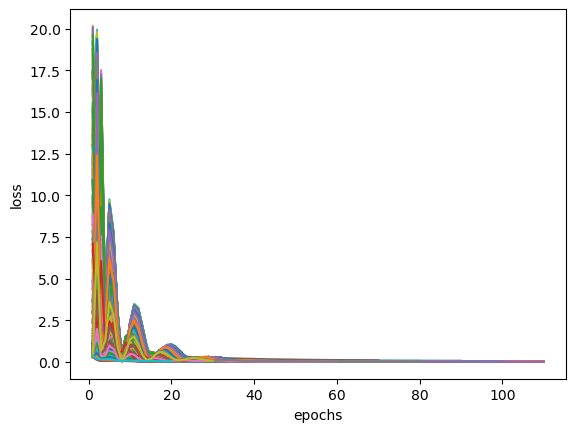

In [15]:
best_results_acc = []

# repeat search process 10,000 times
for i in range(1000):
    
    seed = random_nm[i]
    
    acc_score, acc_std, hyperparams = hyperparameter_search(k_splits = 7)
    
    # append accuracy score and set of hyperparameters as tuple
    best_results_acc.append((acc_score, acc_std, hyperparams))

# sort the results by accuracy 
best_results_acc.sort(reverse=True, key=lambda x: x[0])

# select the top results
top_10_acc = best_results_acc[:10]

In [16]:
top_10_acc

[(0.7757936507936508,
  0.11701303728402165,
  {'ae': {'batchsize': 32,
    'learningrate': 0.06543242320363778,
    'epoch': 110,
    'latent': 66},
   'snf': {'K': 14, 'mu': 0.151},
   'gcn': {'epochs': 206,
    'learningrate': 0.025637354888124755,
    'weight_decay': 0.008872990433214052,
    'hidden': 128,
    'dropout': 0.6432983088374701}}),
 (0.7757936507936508,
  0.14403723343556774,
  {'ae': {'batchsize': 32,
    'learningrate': 0.029126623011806803,
    'epoch': 110,
    'latent': 52},
   'snf': {'K': 5, 'mu': 0.175},
   'gcn': {'epochs': 250,
    'learningrate': 0.02835624177723156,
    'weight_decay': 0.01682846198715123,
    'hidden': 32,
    'dropout': 0.4423671684166517}}),
 (0.7718253968253969,
  0.12507871041646418,
  {'ae': {'batchsize': 32,
    'learningrate': 0.07704111903747646,
    'epoch': 90,
    'latent': 46},
   'snf': {'K': 7, 'mu': 0.158},
   'gcn': {'epochs': 260,
    'learningrate': 0.07080744339191732,
    'weight_decay': 0.028623823503673516,
    'hidde